In [1]:
import numpy as np
import random
from scipy.special import expit
from scipy.io import loadmat
import tqdm
from sklearn.preprocessing import scale
import time
import math
import matplotlib.pyplot as plt
import csv

In [167]:
def tanhDerivative(numHiddenNodes, h):
    return (np.ones(numHiddenNodes) - np.multiply(h[:-1], h[:-1]))
def reluDerivative(numHiddenNodes, h):
    return h * (h > 0)
def tanh(x):
    return np.tanh(x)
def relu(x):
    return 1 * (x > 0)
def protectedLog(x):
    if x == 0:
        return 1
    else:
        return math.log(x, 2)
def trainNeuralNetwork(images, labels, numHiddenNodes, inputLRate, hiddenLRate, count, hiddenLayerBack, hiddenLayerForward, miniBatch=0):
#     ms = time.clock()
    W = np.random.normal(0,.1, (26,numHiddenNodes + 1))
    V = np.random.normal(0,.1, (numHiddenNodes, images.shape[1] + 1))
    losses = []
    iShape = images.shape
#     sTime = 0
    for i in tqdm.tqdm(range(count)):
#         ep1 = (1/(i+1)) * inputLRate
#         ep2 = (1/(i+1)) * hiddenLRate
        ep1 = inputLRate
        ep2 = hiddenLRate
        if miniBatch == 0:
            pickedPoint = random.randint(0, iShape[0] - 1)
            x = np.append(images[pickedPoint], 1)
            y = np.zeros(26)
            y[labels[pickedPoint] - 1] = 1.0
        else:
            seeds = np.random.randint(0, high=iShape[0] - 1, size=miniBatch)
            x = np.zeros((iShape[1], miniBatch)).T
            y = np.zeros((26, miniBatch)).T
            for i, item in enumerate(seeds):
                x[i] = images[item]
                ys = np.zeros(26)
                ys[labels[item] - 1] = 1.0
                y[i] = ys
            x = x.T
            x = np.vstack((x, np.ones((1, miniBatch))))
            y = y.T
        h = hiddenLayerForward(V.dot(x))
        if miniBatch == 0:
            h = np.append(h, 1)
        else:
            h = np.append(h, np.ones((1, miniBatch)), axis=0)
        z = expit(W.dot(h))
        if miniBatch == 0:
            logLoss = 0
            for j in range(len(z)):
                log = (y[j] * protectedLog(z[j]) + (1 - y[j]) * (1 - protectedLog(z[j])))
                logLoss -= log
    #         if logLoss < -350:
    #             break
    #         if i % 500 == 0:
            losses.append(logLoss)
        if miniBatch == 0:
            wPrime = np.outer(z - y,h)
        else:
            wPrime = (z-y).dot(h.T)
        wzy = W.T.dot(z - y) #201 x n
#         vPrime = np.zeros((numHiddenNodes, iShape[1] + 1))
        #26 %
#         start = time.clock()
        if miniBatch == 0:
            vPrime = np.outer(np.multiply(wzy[:-1], hiddenLayerBack(numHiddenNodes, h[:-1])), x)
        else:
            vPrime = wzy.dot(x.T)[0:-1]
#         vPrime = np.delete(vPrime, (200), axis=0)
#         sTime += time.clock() - start
#         for i in range(numHiddenNodes):
#             vPrime[i] = wzy[i]*(1 - h[i]*h[i]) * x
        #Learn
        #21 %
        if miniBatch == 0:
            wPrime = ep1 * wPrime
            vPrime = ep2 * vPrime
        else:
            wPrime = ep1/miniBatch * wPrime
            vPrime = ep2/miniBatch * vPrime
        #25 %
        W = np.subtract(W,wPrime)
        V = np.subtract(V,vPrime)
        count -= 1

#     print(sTime/(time.clock() - ms))
    return W, V, losses
def predictNeuralNetwork(images, W, V, hiddenLayerForward):
    output = []
    for i in tqdm.tqdm(images):
        x = np.append(i, 1)
        h = hiddenLayerForward(V.dot(x))
        h = np.append(h, 1)
        z = expit(W.dot(h))
        hot = np.zeros(W.shape[0])
        prediction = z.argmax()
        output.append([prediction + 1])
    return output

In [48]:
def compare(actual, experimental):
    correct = 0
#     corrArray = []
#     incArray = []
    total = len(actual)
    for i in range(total):
        if actual[i][0] == experimental[i][0]:
            correct += 1
#             corrArray.append(i)
#         else:
#             incArray.append((i, experimental[i][0]))
#     print(corrArray[:5])
#     print(incArray[:5])
    return correct/total

In [4]:
#Form training and validation sets
def createTrainValSet(trainingSize, validationSize):
    lettersData = loadmat("hw6_data_dist/letters_data.mat")
    training = lettersData['train_x']
    labels = lettersData['train_y']
    training = scale(training, axis=1)
    chosen = set()
    trainingData = []
    trainingLabels = []
    validationData = []
    validationLabels = []
    for i in tqdm.tqdm(range(trainingSize)):
        choice = random.randint(0, len(training) - 1)
        while choice in chosen:
            choice = random.randint(0,len(training) - 1)
        chosen.add(choice)
        trainingData.append(training[choice])
        trainingLabels.append(labels[choice])

    for j in tqdm.tqdm(range(validationSize)):
        choice = random.randint(0, len(training) - 1)
        while choice in chosen:
            choice = random.randint(0,len(training) - 1)
        chosen.add(choice)
        validationData.append(training[choice])
        validationLabels.append(labels[choice])
    return trainingData, trainingLabels, validationData, validationLabels

In [5]:
trainingData, trainingLabels, validationData, validationLabels = createTrainValSet(99840, 24960)
# trainingData, trainingLabels, validationData, validationLabels = createTrainValSet(100, 0)

/Users/akilesh/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
100%|██████████| 24960/24960 [00:02<00:00, 11816.88it/s]


100%|██████████| 39000/39000 [07:32<00:00, 86.24it/s]


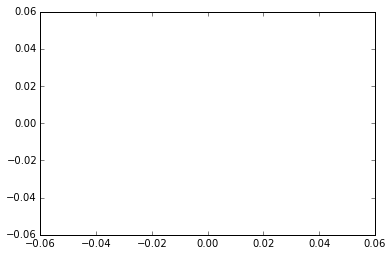

In [177]:
%matplotlib inline
# for i in [.01,.05,.1,.2,.3,.35,.4,.45]:
W, V, losses = trainNeuralNetwork(np.array(trainingData), np.array(trainingLabels), 200,.05, .05, int(99840 * 100/256), reluDerivative, relu, 256)
# W, V, losses = trainNeuralNetwork(np.array(trainingData), np.array(trainingLabels), 200,.1, .1, int(99840 * 2/50), tanhDerivative, tanh, 50)

# W, V, losses = trainNeuralNetwork(np.array(trainingData), np.array(trainingLabels), 200,.1, .1, 100000)


plt.plot(losses)
plt.show()

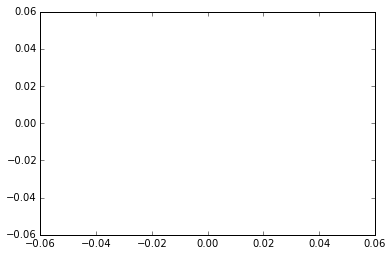

In [131]:
sampledLosses = losses[0::500]
plt.plot(sampledLosses)
plt.show()

In [178]:
outputs = predictNeuralNetwork(validationData, W, V, relu)
print(compare(validationLabels, outputs))

100%|██████████| 24960/24960 [00:02<00:00, 11134.73it/s]

0.7353766025641025


[4]


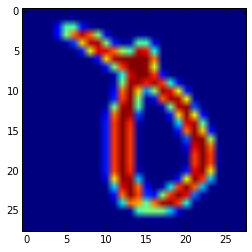

In [46]:
def show(i):
    res = np.reshape(validationData[i], (28, 28))
    plt.imshow(res)
    plt.figure(i)
show(25)
print(validationLabels[25])

In [54]:
lettersData = loadmat("hw6_data_dist/letters_data.mat")
testx = lettersData['test_x']
testx = scale(testx, axis=1)
answers = predictNeuralNetwork(testx, W, V)
f = open('nnbare.csv', 'wt')
try:
    writer = csv.writer(f)
    writer.writerow( ('Id', 'Category') )
    for i in range(len(testx)):
        writer.writerow( (i, str(answers[i][0])) )
finally:
    f.close()

/Users/akilesh/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
100%|██████████| 20800/20800 [00:01<00:00, 13557.50it/s]


In [46]:
print(min(losses))

-539.127473216
